In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cmap
import cartopy.feature as cFeature

# Regrid temperature data from multiple models to same grid

In [4]:
# Load climate indicies

SPG_models = ['NorESM2-LM_ssp245', 'MRI-ESM2-0_ssp245', 'CESM2-WACCM_ssp245']
SPG_models = ['NorESM2-LM_ssp245', 'MRI-ESM2-0_ssp245']

start_time = '2015-01-01'; end_time = '2060-01-01'
data_folder = '../CMIP6_data/'
files = glob.glob(data_folder+'tas_day_'+SPG_models[0]+'*')
files.sort()
ds1 = xr.open_mfdataset(files)
ds1 = ds1.sel(time=slice(start_time, end_time))
SPG_ds = ds1.copy()
for i in range(1, len(SPG_models)):
    files = glob.glob(data_folder+'tas_day_'+SPG_models[i]+'*')
    files.sort()
    ds2 = xr.open_mfdataset(files)
    ds2 = ds2.sel(time=slice(start_time, end_time))
    ds2 = ds2.interp_like(ds1, kwargs={"fill_value": "extrapolate"})
    SPG_ds = xr.concat([SPG_ds, ds2], dim = 'model')


non_SPG_models = ['UKESM1-0-LL_ssp245', 'MPI-ESM1-2-LR_ssp245', 'GFDL-ESM4_ssp245']
non_SPG_models = ['MPI-ESM1-2-LR_ssp245', 'GFDL-ESM4_ssp245']

start_time = '2015-01-01'; end_time = '2060-01-01'
data_folder = '../CMIP6_data/'
files = glob.glob(data_folder+'tas_day_'+non_SPG_models[0]+'*')
files.sort()
ds1_1 = xr.open_mfdataset(files)

ds1_1 = ds1_1.sel(time=slice(start_time, end_time))
ds1_1 = ds1_1.interp_like(ds1)

non_SPG_ds = ds1_1.copy()
for i in range(1, len(non_SPG_models)):
    files = glob.glob(data_folder+'tas_day_'+non_SPG_models[i]+'*')
    files.sort()
    ds2 = xr.open_mfdataset(files)
    ds2 = ds2.sel(time=slice(start_time, end_time))
    ds2 = ds2.interp_like(ds1_1, kwargs={"fill_value": "extrapolate"})
    non_SPG_ds = xr.concat([non_SPG_ds, ds2], dim = 'model')

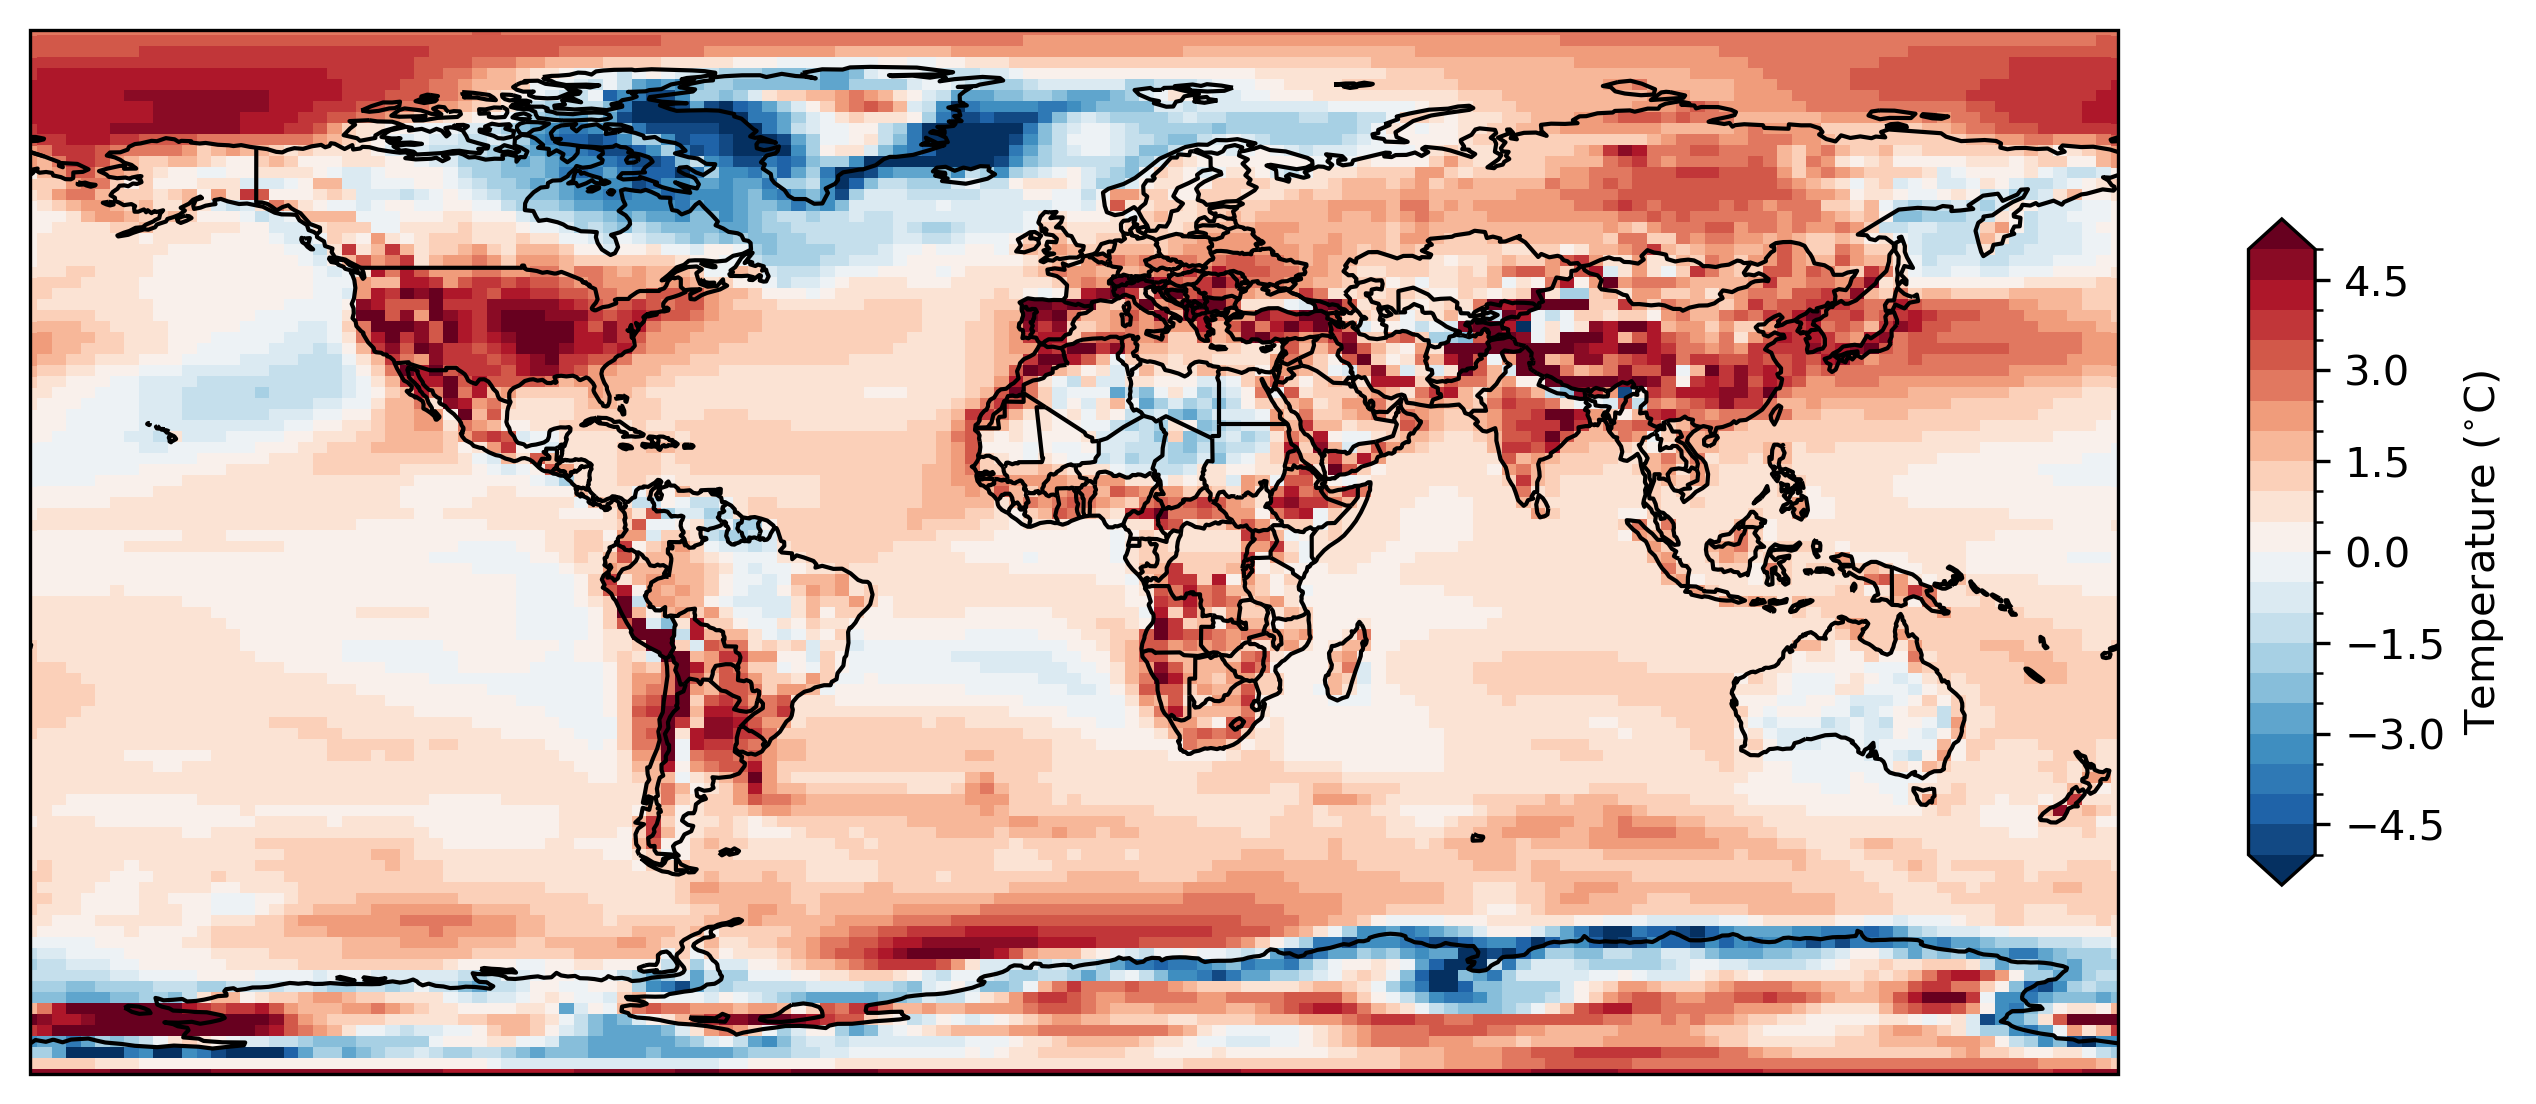

In [5]:
# Plot temperature
lmax_tas = 5
levels = np.linspace(-lmax_tas, lmax_tas, 21)
fig = plt.figure(figsize=[9, 4], dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
SPG_mean = SPG_ds.tas.mean('model').sel(time=slice('2040-01-01', '2050-01-01')).mean('time')
non_SPG_mean = non_SPG_ds.tas.mean('model').sel(time=slice('2040-01-01', '2050-01-01')).mean('time')

diff = SPG_mean-non_SPG_mean

map = diff.plot(ax=ax, 
            transform=ccrs.PlateCarree(),levels=levels, cmap='RdBu_r',
            cbar_kwargs={'orientation':'vertical','shrink':0.6, 'aspect':10,'label':'Temperature ($^{\circ}$C)'})
ax.coastlines()
ax.add_feature(cFeature.BORDERS)
ax.set_title('')
fig.tight_layout()
plt.show()

In [ ]:
# Interpolate
data_folder = '../CMIP6_data/'
start_time1 = '2015-01-01'; end_time1 = '2035-01-01'
start_time2 = '2040-01-01'; end_time2 = '2060-01-01'
variable = 'tas'

SPG_models = ['NorESM2-LM_ssp245', 'MRI-ESM2-0_ssp245', 'CESM2-WACCM_ssp245']
non_SPG_models = ['MPI-ESM1-2-LR_ssp245', 'GFDL-ESM4_ssp245']

# Combine 
files = glob.glob(data_folder+variable+'_day_'+SPG_models[0]+'*')
files.sort()
ds = xr.open_mfdataset(files)
ds1 = ds[variable].sel(time=slice(start_time1, end_time1)).mean("time")
ds2 = ds[variable].sel(time=slice(start_time2, end_time2)).mean("time")

SPG_models_pre = ds1.copy()
SPG_models_post = ds2.copy()
for i in range(1, len(SPG_models)):
    print('new model')
    files = glob.glob(data_folder+variable+'_day_'+SPG_models[i]+'*')
    files.sort()
    ds_i = xr.open_mfdataset(files)
    ds_i1 = ds_i[variable].sel(time=slice(start_time1, end_time1)).mean("time")
    ds_i2 = ds_i[variable].sel(time=slice(start_time2, end_time2)).mean("time")
    print(ds_i1.isel(lat=0, lon=0).values)
    ds_i1 = ds_i1.interp_like(ds1, kwargs={"fill_value": "extrapolate"})
    ds_i2 = ds_i2.interp_like(ds2, kwargs={"fill_value": "extrapolate"})
    print(ds_i1.isel(lat=0, lon=0).values)

    SPG_models_pre = xr.concat([SPG_models_pre, ds_i1], dim = 'model')
    SPG_models_post = xr.concat([SPG_models_post, ds_i2], dim = 'model')

# Combine
files = glob.glob(data_folder+variable+'_day_'+non_SPG_models[0]+'*')
files.sort()
ds_non = xr.open_mfdataset(files)
ds1_non = ds_non[variable].sel(time=slice(start_time1, end_time1)).mean("time")
ds2_non = ds_non[variable].sel(time=slice(start_time2, end_time2)).mean("time")
ds1_non = ds1_non.interp_like(ds1, kwargs={"fill_value": "extrapolate"})
ds2_non = ds2_non.interp_like(ds2, kwargs={"fill_value": "extrapolate"})
print(ds1_non)
non_SPG_models_pre = ds1_non.copy()
non_SPG_models_post = ds2_non.copy()
for i in range(1, len(non_SPG_models)):
    print('new model')
    files = glob.glob(data_folder+variable+'_day_'+non_SPG_models[i]+'*')
    files.sort()
    ds_i = xr.open_mfdataset(files)
    ds_i1 = ds_i[variable].sel(time=slice(start_time1, end_time1)).mean("time")
    ds_i2 = ds_i[variable].sel(time=slice(start_time2, end_time2)).mean("time")
    print(ds_i1.isel(lat=0, lon=0).values)
    print(ds_i1)
    ds_i1 = ds_i1.interp_like(ds1, kwargs={"fill_value": "extrapolate"})
    ds_i2 = ds_i2.interp_like(ds2, kwargs={"fill_value": "extrapolate"})
    print(ds_i1.isel(lat=0, lon=0).values)

    non_SPG_models_pre = xr.concat([non_SPG_models_pre, ds_i1], dim = 'model')
    non_SPG_models_post = xr.concat([non_SPG_models_post, ds_i2], dim = 'model')

In [ ]:
# Plot temperature
lmax_tas = 2
levels = np.linspace(-lmax_tas, lmax_tas, 21)
fig = plt.figure(figsize=[9, 4], dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff_SPG_mean = SPG_models_post.mean('model') - SPG_models_pre.mean('model')
diff_non_SPG_mean = non_SPG_models_post.mean('model') - non_SPG_models_pre.mean('model')
diff = diff_SPG_mean-diff_non_SPG_mean
#if area_name == 'europe':
#    diff = diff.reindex({'lon':pr.lon})
#    ax.set_xlim([-50, 33])

map = diff.plot(ax=ax, 
            transform=ccrs.PlateCarree(),levels=levels, cmap='RdBu_r',
            cbar_kwargs={'orientation':'vertical','shrink':0.6, 'aspect':10,'label':'Temperature ($^{\circ}$C)'})
ax.coastlines()
ax.add_feature(cFeature.BORDERS)
ax.set_title('')
fig.tight_layout()
plt.show()
